In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from numpy import pi

import bateman as bt
import thermalization as th
import heat as ht
import lightcurve as lc

from astropy import constants as const


c = const.c.cgs.value
day = 86400.
Msun = const.M_sun.cgs.value


%matplotlib inline
%load_ext autoreload
%autoreload 2

<font size="4.5"> 
- Read effective opacities to gamma-rays for each elements<br>
</font>

In [2]:
#fkappa = pd.read_csv('effective_kappa_A141_238.dat',delim_whitespace=True,header=None)
fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)
#fkappa = pd.read_csv('effective_kappa_141_238.dat',delim_whitespace=True,header=None)

kappa_effs = 0.02*np.ones((240,100))
for i in range(0,len(fkappa)):
    A = fkappa[0][i]
    Z = fkappa[1][i]
    kappa = np.sqrt(fkappa[3][i]*fkappa[4][i])
    kappa_effs[A][Z] = kappa

<font size="4.5"> 
- Read abundances of each beta-decay chain <br>
</font>
The file format is
(Z A Y), where Z is an atomic number, A is an atomic mass number, and Y is a number fraction. The following example file corresponds to the solar r-process pattern with A>=70. (beta-decay chains between A=50 and 209 can be included.)

In [3]:
ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)

<font size="4.5">
- Define the range of atomic numbers of beta-decay chains and the ejecta model (density profile). <br>
</font>
We use a radial density profile of merger ejecta with a total mass of 
$M_{\rm ej}$ and a minimum velocity of $v_0$:
\begin{eqnarray}
  \rho(t,v) = 
        \rho_0(t)\left(\frac{v_{\rm ej}}{v_0}\right)^{-n}~{\rm for}~(v_0\leq v_{\rm ej}\leq v_{\rm max})
\end{eqnarray}
where $\rho_0(t)$ is defined such that 
\begin{eqnarray}
M_{\rm ej} = 4\pi \int_{v_0}^{v_{\rm max}}dvv^2 \rho(t,v).
\end{eqnarray}


In [4]:
##########Start input parameters
Amin = 85
Amax = 209

##########ejecta parameters for thermalization
Mej = 0.05*Msun
vej = 0.1*c
n = 4.5
alpha_max = 4.0#v_max = alpha_max * vej
alpha_min = 1.#v_min = alpha_min * vej

<font size="4.5"> 
- Calculate the beta decay radioactive power and heating rate <br>
</font>

In [5]:
beta = ht.calc_heating_rate(Mej,vej, Amin,Amax,ffraction,kappa_effs,alpha_max,alpha_min,n)

<font size="4.5"> 
- Write the data to a file<br>
</font>
t:[day], heating rates: [erg/s/g]

In [6]:
data = {'t':beta['t'],'total':beta['total'],'gamma':beta['gamma'], 'electron':beta['electron'], 'gamma_th':beta['gamma_th'],'electron_th':beta['electron_th']}
df = pd.DataFrame(data=data)
df.to_csv('output_files/heat85_209_M005_v04_v1_n45.dat',sep=" ",index=False,header=None,columns=['t', 'total', 'gamma', 'electron','gamma_th','electron_th'])

<font size="4.5"> 
- Plot the data <br>
</font>

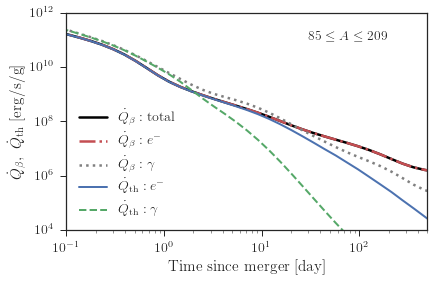

In [7]:
from matplotlib import rc
rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(6.472135955, 4))
plt.xlim(0.1,500.)
plt.ylim(1.0e4,1.0e12)
plt.ylabel(r"$\dot{Q}_{\beta},~\dot{Q}_{\rm th}~[{\rm erg/s/g}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.loglog(beta['t'],beta['electron'],label=r'$\dot{Q}_{\beta}:e^{-}$',linestyle='-.',linewidth=2.5,color='C2')
plt.loglog(beta['t'],beta['gamma'],label=r'$\dot{Q}_{\beta}:\gamma$',linestyle=':',linewidth=2.5,color='grey')
plt.loglog(beta['t'],beta['electron_th'],label=r'$\dot{Q}_{\rm th}:e^{-}$',linestyle='-',linewidth=2.,color='C0')
plt.loglog(beta['t'],beta['gamma_th'],label=r'$\dot{Q}_{\rm th}:\gamma$',linestyle='--',linewidth=2.,color='C1')

plt.text(30,1.0e11,'$85\leq A\leq 209$',fontsize=13.5)

plt.legend(loc='lower left',fontsize=14)
plt.savefig("output_files/heat_A85.pdf",dpi=600,bbox_inches='tight')
plt.show()

<font size="4.5"> 
- Bolometric light curve and temperature at the photosphere<br>
</font>
The opacities of the inner and outer parts of the ejecta are set to be
\begin{eqnarray}
\kappa=\kappa_{\rm high}~{\rm for}~(v\leq v_{\kappa})~~~~{\rm and}~~~~\kappa=\kappa_{\rm low}~{\rm for}~(v>v_{\kappa})
\end{eqnarray}

In [8]:
#input parameters for the calculation of a light curve
kappa_low = 0.5  #opacity [cm^2/g] for v > v_kappa
kappa_high = 3.0 #opacity [cm^2/g] for v < v_kappa
be_kappa = 0.2

heat_time = np.array(beta['t'])
heat_rate = np.array(beta['electron_th'])+np.array(beta['gamma_th'])

<font size="4.5"> 
- Compute the bolometric light curve and temperature at the photosphere<br>
</font>

In [9]:
LC = lc.calc_lightcurve(Mej,vej,alpha_max,alpha_min,n,kappa_low,kappa_high,be_kappa,heat_time, heat_rate)

<font size="4.5"> 
- Write the data to a file<br>
</font>
t: [day], light curve: [erg/s], temperature: [K]

In [10]:
data = {'t':LC['t'],'LC':LC['LC'],'Temp':LC['T']}
df = pd.DataFrame(data=data)
df.to_csv('output_files/lightcurve.dat',sep=" ",index=False,header=None,columns=['t', 'LC', 'Temp'])

<font size="4.5"> 
- Plot the bolometric light curve <br>
</font>

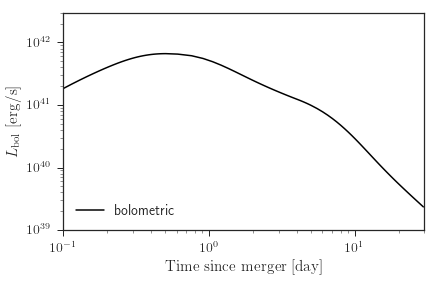

In [11]:
from matplotlib import rc
rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(6.472135955, 4))
plt.xlim(0.1,30.)
plt.ylim(1.0e39,3.0e42)
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.loglog(LC['t'],LC['LC'],label='bolometric',linestyle='-',linewidth=1.5,color='k')

#plt.text(30,1.0e11,'$88\leq A\leq 209$',fontsize=13.5)

plt.legend(loc='lower left',fontsize=14)
plt.savefig("output_files/LC_A85.pdf",dpi=600,bbox_inches='tight')
plt.show()